## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Алибаева Камила Винеровна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [10]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [11]:
images_train, labels_train = next(iter(train_loader))

In [12]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

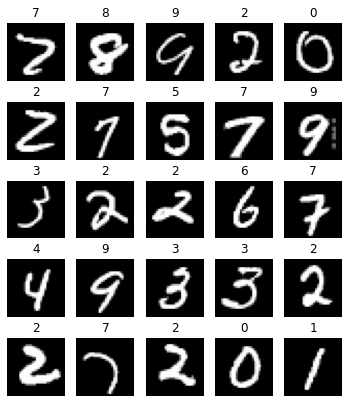

In [13]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [14]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)
    
def init_layer_uniform(layer, low=-1.0, high=1.0):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #torch.nn.init.xavier_uniform_(weight)
    weight.uniform_(low, high)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    forward_std.append(std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    backward_std.append(std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [15]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    return np.sqrt(6. / (size_input + size_output))

def he(size_input, size_output):
    return np.sqrt(2. / size_input)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

init_func = normal
#init_func = xavier
#init_func = he

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    layers.append(nn.Sigmoid())
    #layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
forward_std = []
backward_std = []

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

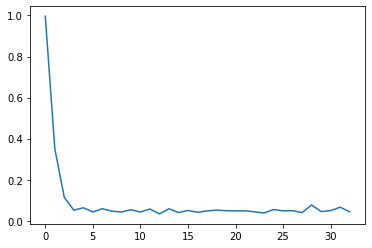

In [9]:
plt.plot(range(len(forward_std)), forward_std)

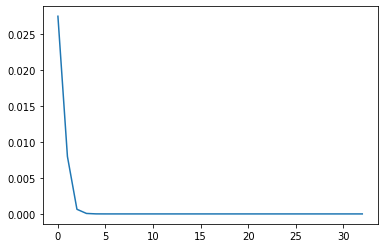

In [10]:
plt.plot(range(len(backward_std)), backward_std)

In [11]:
np.mean(np.std(activations.detach().numpy(), axis=1))

0.2054028

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [12]:
# He initialization

init_func = he
layers = []
forward_std = []
backward_std = []

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output))
    
    layers.append(layer)
    layers.append(nn.ReLU())
    
del layers[-1]

network = nn.Sequential(*layers)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

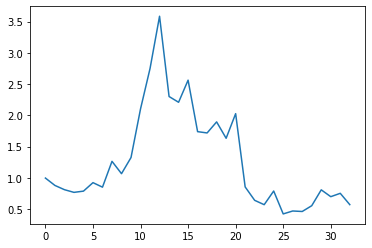

In [13]:
plt.plot(range(len(forward_std)), forward_std)

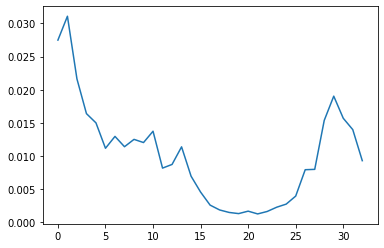

In [14]:
plt.plot(range(len(backward_std)), backward_std)

In [15]:
np.mean(np.std(activations.detach().numpy(), axis=1))

0.71691793

In [16]:
# Xavier initialization

init_func = xavier
layers = []
forward_std = []
backward_std = []

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer_uniform(layer, low=-init_func(size_input, size_output), high=init_func(size_input, size_output))
    
    layers.append(layer)
    layers.append(nn.Tanh())
    
del layers[-1]

network = nn.Sequential(*layers)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

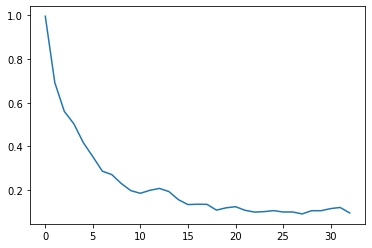

In [17]:
plt.plot(range(len(forward_std)), forward_std)

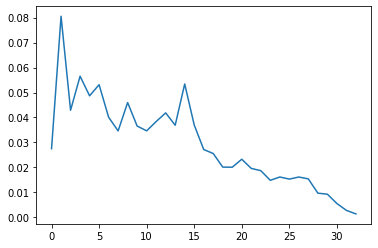

In [18]:
plt.plot(range(len(backward_std)), backward_std)

In [19]:
np.mean(np.std(activations.detach().numpy(), axis=1))

0.10028126

На графиках для стандартных отклонений градиентов видно, что с использованием Xavier и He градиенты перестали сильно уменьшаться и инициализация весов для соответствующих функций позволила избежать vanishing gradients, как в первом случае

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [20]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [20]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [21]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    #layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.034/0.060	Accuracy: 0.988/0.981


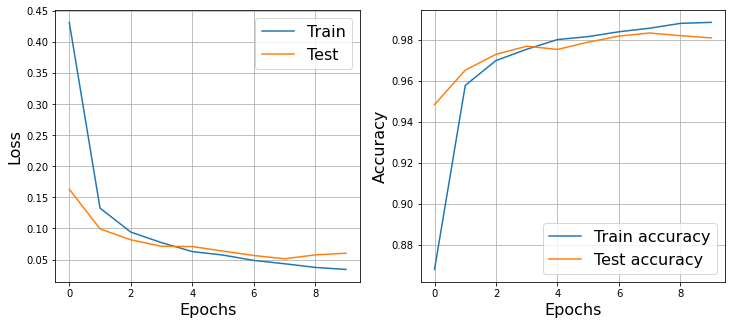

CPU times: user 2min 54s, sys: 7.6 s, total: 3min 2s
Wall time: 2min 53s


([0.4310643710116588,
  0.13269967883666442,
  0.09424207936614942,
  0.07726783728373966,
  0.06295188407856486,
  0.0572730391842327,
  0.04873565727396052,
  0.0433842218942694,
  0.03750091441460192,
  0.034216092296762826],
 [0.16302977950323985,
  0.09934674682024913,
  0.08179692025709001,
  0.07135524909613253,
  0.07099357688257212,
  0.06371545938987143,
  0.05664363491077778,
  0.05134113738313317,
  0.05760792151824394,
  0.06026269421217185],
 [0.8680149,
  0.9577503,
  0.9698772,
  0.9753743,
  0.98009396,
  0.9815432,
  0.98390305,
  0.985641,
  0.98799527,
  0.98848945],
 [0.94837815,
  0.9651899,
  0.9729035,
  0.97685915,
  0.9752769,
  0.978837,
  0.9818038,
  0.98328716,
  0.9820016,
  0.98091376])

In [23]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.450/0.056	Accuracy: 0.782/0.984


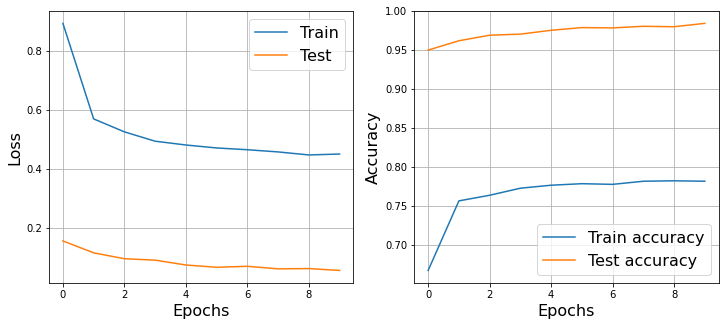

CPU times: user 2min 56s, sys: 8.18 s, total: 3min 4s
Wall time: 2min 55s


([0.8936141444675958,
  0.5695651331817163,
  0.5256785758014427,
  0.49395759311566223,
  0.4811029143806205,
  0.4710889222906597,
  0.4650482114062889,
  0.457643155095928,
  0.44736577313083575,
  0.4504634785309021],
 [0.15578258711891838,
  0.11539617888157881,
  0.09552560473167443,
  0.09063069319611863,
  0.07419525407537629,
  0.06646700499319955,
  0.06974136528169995,
  0.061121332459151745,
  0.06205548753348898,
  0.05571062114867795],
 [0.6669998,
  0.7563022,
  0.7635039,
  0.7725768,
  0.77639705,
  0.7783571,
  0.77750754,
  0.78151655,
  0.7820829,
  0.7815054],
 [0.9498615,
  0.9618275,
  0.96894777,
  0.97033226,
  0.9752769,
  0.9787381,
  0.9783426,
  0.9804193,
  0.979826,
  0.98417723])

In [24]:
%%time

sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    #layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.120/0.118	Accuracy: 0.963/0.979


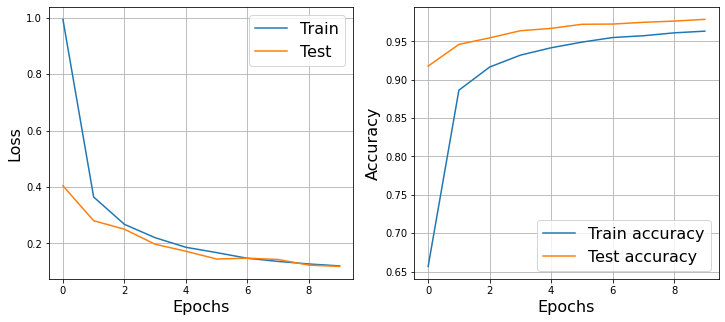

CPU times: user 3min 4s, sys: 18.6 s, total: 3min 22s
Wall time: 3min 13s


([0.99468805432828,
  0.3643955891765257,
  0.26751951434846116,
  0.22003879524402017,
  0.1860291058702001,
  0.16714891036356816,
  0.1469860182626288,
  0.1358934034631133,
  0.12681278439044064,
  0.1199476150974536],
 [0.40436840533644336,
  0.28032542458629306,
  0.25018131306182734,
  0.19686449672791023,
  0.17201913056211238,
  0.14436851221166128,
  0.14737795247649185,
  0.14277829765636899,
  0.12276878787819832,
  0.11803696691824854],
 [0.65672195,
  0.8863495,
  0.9164834,
  0.93200845,
  0.94160897,
  0.94894946,
  0.9549518,
  0.9572839,
  0.9610486,
  0.96326405],
 [0.9177215,
  0.94600475,
  0.9545095,
  0.9638054,
  0.966871,
  0.97221124,
  0.9725079,
  0.9747824,
  0.97636473,
  0.97863925])

In [59]:
%%time

sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    #layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.7)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

#dropconnect
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

У dropout меньше точность на трейне, потому что с dropout происходит зануление целых нейронов, а с dropconnect - только отдельных весов

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [25]:
# полезные функции: .std(dim), .mean(dim)

eps = 10e-5

class LayerNormalization(nn.Module):
    def __init__(self, output_dim):
        super(LayerNormalization, self).__init__()
    
    def forward(self, x):
        mean = torch.mean(x, dim=1)
        std = torch.std(x, dim=1)
        x = (x - mean[:, None]) / torch.sqrt(eps + std[:, None] ** 2)
        output = x
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.016/0.078	Accuracy: 0.995/0.980


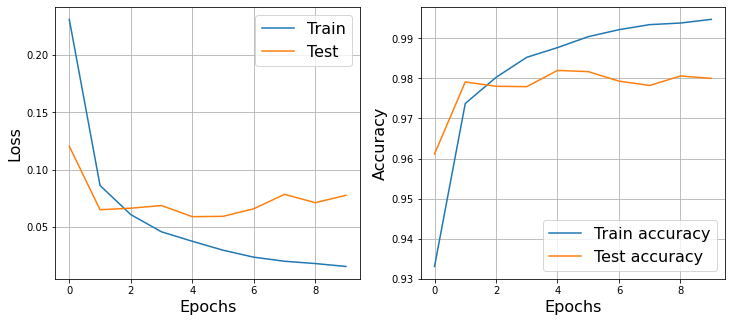

CPU times: user 3min 17s, sys: 20.2 s, total: 3min 37s
Wall time: 3min 25s


([0.23101847212134138,
  0.08632379754392831,
  0.0609197013858539,
  0.045918682754945275,
  0.037705130013289734,
  0.029903651957811195,
  0.023836064639924243,
  0.020285701270211242,
  0.018281743380125424,
  0.015758570283154912],
 [0.12050143874521498,
  0.06516188265802929,
  0.06650233673096835,
  0.06882073055905631,
  0.05911959243844016,
  0.05940314551780024,
  0.06601356503869041,
  0.07857361819618676,
  0.07129824677588348,
  0.07773608366275041],
 [0.9330468,
  0.9737418,
  0.98026055,
  0.98528004,
  0.987701,
  0.9904329,
  0.99218196,
  0.99344236,
  0.99383664,
  0.9947583],
 [0.96113527,
  0.9791337,
  0.9780459,
  0.977947,
  0.9820016,
  0.9817049,
  0.9793315,
  0.97824365,
  0.9806171,
  0.98002374])

In [27]:
%%time

sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(LayerNormalization(size_output))
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

#layernorm
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.343/0.319	Accuracy: 0.992/0.989


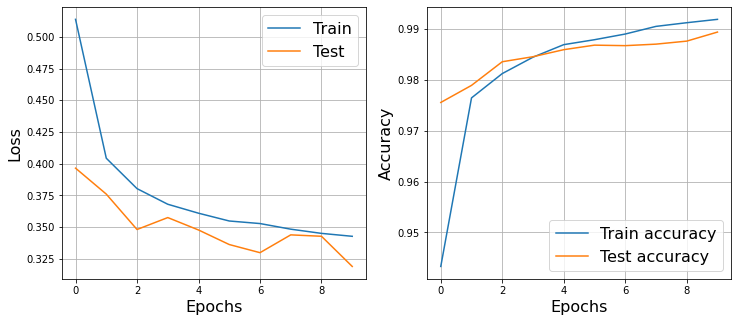

CPU times: user 3min 40s, sys: 9.71 s, total: 3min 49s
Wall time: 3min 11s


([0.5138146618663121,
  0.40427835587499494,
  0.38030649108419035,
  0.3679834048885272,
  0.3609240361368224,
  0.35477871757580526,
  0.3527551872262568,
  0.34832398533058573,
  0.3450074049709702,
  0.342700091442828],
 [0.3964561914341359,
  0.3759845993186854,
  0.3480689495424681,
  0.35747561575491216,
  0.34768676229670076,
  0.3362056877039656,
  0.32978766477560695,
  0.34383148520807677,
  0.3427285321905643,
  0.31892707566671735],
 [0.9433191,
  0.9764737,
  0.98125446,
  0.9844805,
  0.9869458,
  0.9879176,
  0.98903364,
  0.99053836,
  0.9912602,
  0.99192095],
 [0.9755736,
  0.9789359,
  0.98358387,
  0.98457277,
  0.98595726,
  0.9868473,
  0.9867484,
  0.9870451,
  0.9876385,
  0.9894185])

In [28]:
%%time

sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    #layer = LayerNormalization(size_input, size_output)
    
    layers.append(layer)
    layers.append(nn.BatchNorm1d(size_output, affine=False))
    layers.append(nn.ReLU())

del layers[-1]

#batchnorm
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

Встроенный BatchNorm показал результаты на тесте немного выше, чем LayerNormalization

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: